# Disciple - 取引シミュレーション（Jupyter用）

In [1]:
import datetime
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.conv import conv_transaction_df2html
from funcs.setting import load_setting
from funcs.tide import get_date_dir_from_file
from funcs.tse import get_ticker_name_list
from modules.disciple import Disciple
from structs.res import AppRes

In [2]:
res = AppRes()

excel = "ticks_20260113.xlsx"
code = "7011"
# code = "7203"
# code = "8306"
dict_setting = load_setting(res, code)
THRESHOLD_SLOPE = dict_setting["THRESHOLD_SLOPE"]
TURBULENCE = dict_setting["TURBULENCE"]
date_str = get_date_dir_from_file(excel)
print(date_str)

app = Disciple(excel, code, dict_setting)
app.run()

2026/01/13
パラメータ
PERIOD_WARMUP : 180
PERIOD_MA_1 : 170
PERIOD_MA_2 : 500
PERIOD_SLOPE : 5
THRESHOLD_SLOPE : 0.05
PERIOD_RR : 30
TURBULENCE : 35.0
LOSSCUT_1 : -25


In [3]:
# 取引明細
df_transaction = app.getTransaction()
df_transaction["累積損益"] = df_transaction["損益"].fillna(0).cumsum()
print("取引明細")
print(df_transaction)
print(df_transaction["注文日時"].dtype)
print(df_transaction["累積損益"].dtype)

list_html = conv_transaction_df2html(df_transaction)

output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_transaction.html")
print(output)
with open(output, mode="w") as f:
    f.write("\n".join(list_html))

list_trans = df_transaction["注文日時"]
n_trade = len(df_transaction)
total = df_transaction["損益"].sum()
print(f"取引回数: {n_trade} 回 / 総収益: {total} 円/株")

取引明細
    注文番号                          注文日時 銘柄コード  売買  約定単価  約定数量      損益 備考  \
0      1 2026-01-13 09:09:50.084072113  7011  買建  4447   100     NaN      
1      2 2026-01-13 09:10:34.175789118  7011  売埋  4422   100 -2500.0      
2      3 2026-01-13 09:29:12.460344076  7011  売建  4409   100     NaN      
3      4 2026-01-13 09:33:25.095338106  7011  買埋  4421   100 -1200.0      
4      5 2026-01-13 09:33:26.100450993  7011  買建  4423   100     NaN      
5      6 2026-01-13 09:38:36.879946947  7011  売埋  4412   100 -1100.0      
6      7 2026-01-13 09:38:37.885987043  7011  売建  4414   100     NaN      
7      8 2026-01-13 09:57:45.010251999  7011  買埋  4383   100  3100.0      
8      9 2026-01-13 09:57:46.001971006  7011  買建  4383   100     NaN      
9     10 2026-01-13 10:03:37.705154896  7011  売埋  4376   100  -700.0      
10    11 2026-01-13 10:15:41.253031015  7011  買建  4375   100     NaN      
11    12 2026-01-13 10:20:07.970334053  7011  売埋  4370   100  -500.0      
12    13 2026-01-13 

In [4]:
# Matplotlib の共通設定
FONT_PATH = "fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

In [5]:
"""
累積損益のトレンドを作成するための準備
"""

# 元データ
ts = df_transaction["注文日時"]
pl = df_transaction["累積損益"]

# 日付（年月日）だけ取り出す
date = ts.iloc[0].normalize()

# 追加する先頭と末尾の行
start_row = pd.DataFrame({
    "注文日時": [date + pd.Timedelta(hours=9)],
    "累積損益": [0.0],
})

end_row = pd.DataFrame({
    "注文日時": [date + pd.Timedelta(hours=15, minutes=30)],
    "累積損益": [pl.iloc[-1]],
})

# トレンド用 DataFrame を作成
trend_df = pd.concat(
    [start_row, df_transaction[["注文日時", "累積損益"]], end_row],
    ignore_index=True
)

# 注文日時を index にした Series を作成
trend_series = trend_df.set_index("注文日時")["累積損益"]
trend_series

注文日時
2026-01-13 09:00:00.000000000       0.0
2026-01-13 09:09:50.084072113       0.0
2026-01-13 09:10:34.175789118   -2500.0
2026-01-13 09:29:12.460344076   -2500.0
2026-01-13 09:33:25.095338106   -3700.0
2026-01-13 09:33:26.100450993   -3700.0
2026-01-13 09:38:36.879946947   -4800.0
2026-01-13 09:38:37.885987043   -4800.0
2026-01-13 09:57:45.010251999   -1700.0
2026-01-13 09:57:46.001971006   -1700.0
2026-01-13 10:03:37.705154896   -2400.0
2026-01-13 10:15:41.253031015   -2400.0
2026-01-13 10:20:07.970334053   -2900.0
2026-01-13 10:48:15.725090027   -2900.0
2026-01-13 11:13:46.466624022   -2200.0
2026-01-13 12:32:17.266675949   -2200.0
2026-01-13 12:41:55.830775976   -3000.0
2026-01-13 12:57:13.309650898   -3000.0
2026-01-13 13:24:51.751353025    -900.0
2026-01-13 13:29:02.257946014    -900.0
2026-01-13 13:38:56.353595018     200.0
2026-01-13 13:49:39.809824944     200.0
2026-01-13 14:00:55.902138948    1500.0
2026-01-13 14:07:44.804631948    1500.0
2026-01-13 14:17:31.163888931    13

output/2026/01/13/7011_trend_profit.png


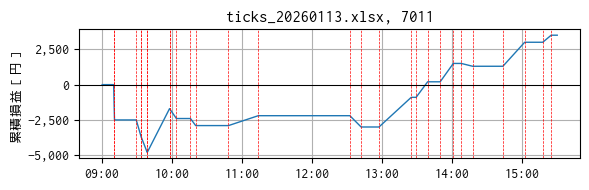

In [6]:
# 累積損益トレンド
fig, ax = plt.subplots(figsize=(6, 2))

ax.set_title(f"{excel}, {code}")
ax.plot(trend_series, linewidth=1)
ax.axhline(y=0, color="black", linewidth=0.75)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("累積損益［円］")
for t in list_trans:
    ax.axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)
ax.grid()

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_trend_profit.png")
print(output)
plt.savefig(output)
plt.show()

In [7]:
# テクニカル指標
print("テクニカル指標")
df_tech = app.getTechnicals()
print(df_tech)

テクニカル指標
                               ts  price          ma1          ma2    slope1  \
2026-01-13 09:06:01  1.768263e+09   4445  4445.000000  4445.000000  0.000000   
2026-01-13 09:06:02  1.768263e+09   4445  4445.000000  4445.000000  0.000000   
2026-01-13 09:06:03  1.768263e+09   4447  4445.666667  4445.666667  0.400000   
2026-01-13 09:06:04  1.768263e+09   4447  4446.000000  4446.000000  0.380952   
2026-01-13 09:06:05  1.768263e+09   4442  4445.200000  4445.200000  0.011111   
...                           ...    ...          ...          ...       ...   
2026-01-13 15:24:45  1.768285e+09   4468  4472.835294  4473.856000  0.030980   
2026-01-13 15:24:46  1.768285e+09   4466  4472.794118  4473.840000  0.035686   
2026-01-13 15:24:46  1.768285e+09   4466  4472.752941  4473.824000  0.039020   
2026-01-13 15:24:48  1.768285e+09   4467  4472.711765  4473.810000  0.040392   
2026-01-13 15:24:49  1.768285e+09   4467  4472.670588  4473.798000  0.041176   

                     rr  profit

In [8]:
df_tech["slope1"].describe()

count    19088.000000
mean         0.033119
std          0.038411
min          0.000000
25%          0.010980
50%          0.023529
75%          0.045882
max          1.619206
Name: slope1, dtype: float64

output/2026/01/13/7011_trend_technical.png


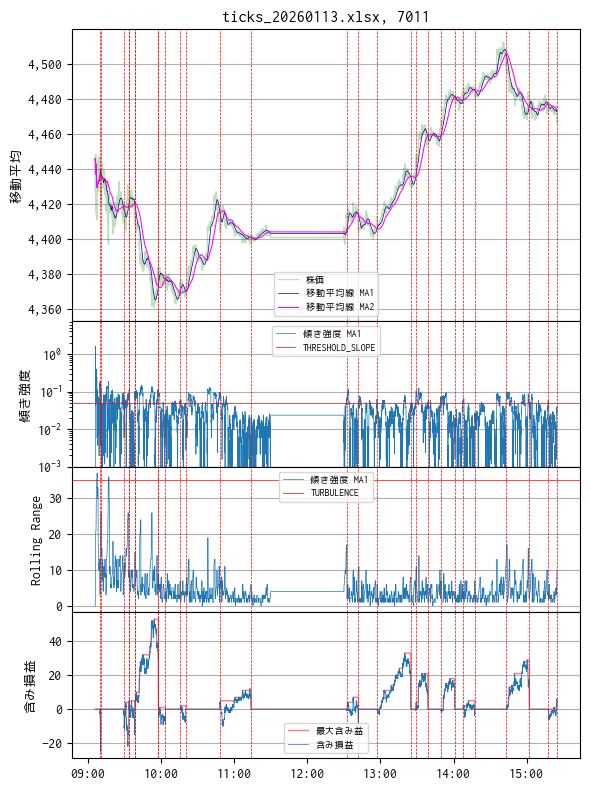

In [9]:
fig = plt.figure(figsize=(6, 8))
n = 4
ax = dict()
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")
ax[0].plot(df_tech["price"], linewidth=1, color="green", alpha=0.25, label="株価")
ax[0].plot(df_tech["ma1"], linewidth=0.5, color="darkblue", label="移動平均線 MA1")
ax[0].plot(df_tech["ma2"], linewidth=0.75, color="magenta", label="移動平均線 MA2")
ax[0].set_ylabel("移動平均")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax[0].legend(fontsize=7)

ax[1].plot(df_tech["slope1"], linewidth=0.5, label="傾き強度 MA1")
ax[1].axhline(y=THRESHOLD_SLOPE, color="red", linewidth=0.5, label="THRESHOLD_SLOPE")
ax[1].set_yscale("log")
ax[1].set_ylabel("傾き強度")
ax[1].legend(fontsize=7)
_, y_high = ax[1].get_ylim()
ax[1].set_ylim(0.001, y_high)

ax[2].plot(df_tech["rr"], linewidth=0.5, label="傾き強度 MA1")
ax[2].axhline(y=TURBULENCE, color="red", linewidth=0.5, label="TURBULENCE")
ax[2].set_ylabel("Rolling Range")
ax[2].legend(fontsize=7)

ax[3].plot(
    df_tech["profit_max"], linewidth=1, color="red", alpha=0.5, label="最大含み益"
)
ax[3].plot(df_tech["profit"], linewidth=0.5, color="C0", label="含み損益")
ax[3].set_ylabel("含み損益")
ax[3].legend(fontsize=7)

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_trend_technical.png")
print(output)
plt.savefig(output)
plt.show()

output/2026/01/13/7011_hist_slope.png


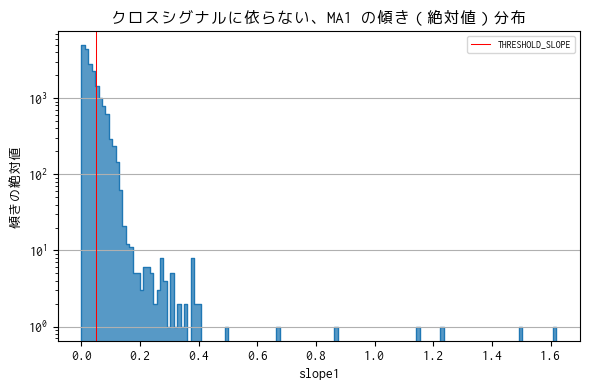

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("クロスシグナルに依らない、MA1 の傾き（絶対値）分布")
sns.histplot(data=df_tech, x="slope1", bins="sqrt", element="step")
ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
ax.set_yscale("log")
ax.set_ylabel("傾きの絶対値")
ax.grid(axis="y")
ax.legend(fontsize=7)

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_hist_slope.png")
print(output)
plt.savefig(output)
plt.show()

output/2026/01/13/7011_hist_rr.png


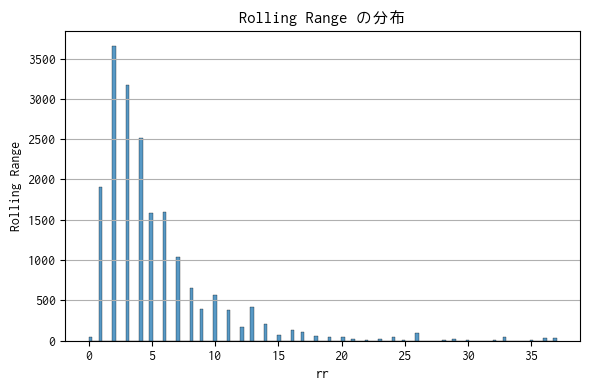

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Rolling Range の分布")
sns.histplot(data=df_tech, x="rr", bins="sqrt")
# ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
# ax.set_yscale("log")
ax.set_ylabel("Rolling Range")
ax.grid(axis="y")
# ax.legend(fontsize=7)

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_hist_rr.png")
print(output)
plt.savefig(output)
plt.show()

In [12]:
# 観測値
print("観測値")
df_obs = app.getObservations()
print(df_obs)

観測値
                     クロスS1  クロスS2  クロ強  乱高下  ロス1   建玉
2026-01-13 09:06:01    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-13 09:06:02    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-13 09:06:03    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-13 09:06:04    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-13 09:06:05    0.0    0.0  0.0  0.0  0.0  0.0
...                    ...    ...  ...  ...  ...  ...
2026-01-13 15:24:45    0.0    0.0  0.0  0.0  0.0 -1.0
2026-01-13 15:24:46    0.0    0.0  0.0  0.0  0.0 -1.0
2026-01-13 15:24:46    0.0    0.0  0.0  0.0  0.0 -1.0
2026-01-13 15:24:48    0.0    0.0  0.0  0.0  0.0 -1.0
2026-01-13 15:24:49    0.0    0.0  0.0  0.0  0.0 -1.0

[19088 rows x 6 columns]


output/2026/01/13/7011_trend_obs.png


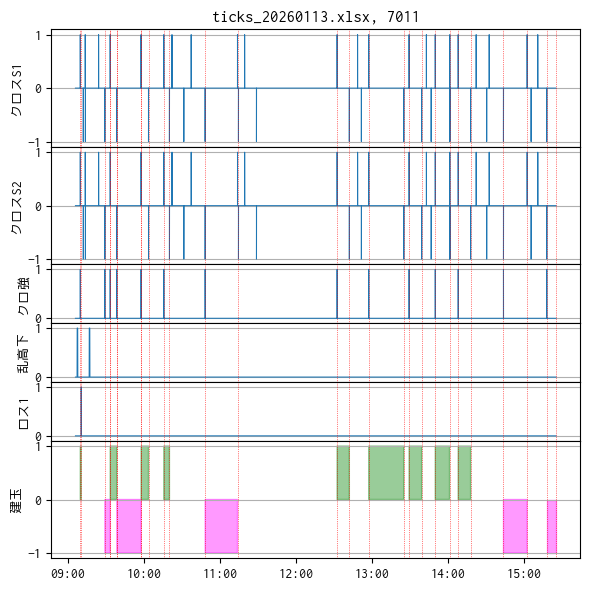

In [13]:
n = len(df_obs.columns)
fig = plt.figure(figsize=(6, n))
ax = dict()

targets = {"クロスS1", "クロスS2", "建玉"}
list_height_ratio = [2 if col in targets else 1 for col in df_obs.columns]
gs = fig.add_gridspec(n, 1, wspace=0.0, hspace=0.0, height_ratios=list_height_ratio)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")

special_cross = {"クロスS1", "クロスS2"}

for i, colname in enumerate(df_obs.columns):
    ax_i = ax[i]

    if colname in special_cross:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-1.1, 1.1)

    elif colname == "建玉":
        x = df_obs.index
        y = df_obs[colname]
        ax_i.fill_between(
            x, 0, y, where=y > 0, color="green", alpha=0.4, interpolate=True
        )
        ax_i.fill_between(
            x, 0, y, where=y < 0, color="magenta", alpha=0.4, interpolate=True
        )
        ax_i.set_ylim(-1.1, 1.1)

    else:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-0.1, 1.1)

    ax_i.set_ylabel(colname)
    ax_i.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dotted", linewidth=0.5)

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_trend_obs.png")
print(output)
plt.tight_layout()
plt.savefig(output)
plt.show()